### Objective: To run descriptor pipeline on antibodies from Kraft et al paper. 
The descriptor paper of interest used the heparin binding data from the Kraft et al paper 2020.In this notebook, I am going to calculate my set of descriptors on that set. 

In this notebook I used De Novo predicted structures from AbBuilder2. 
After producing the Antibodies. I needed to renumber them. 

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from developability.pipeline import run_processing_pipeline
from developability.utils import ls, renumber_pdb, plot_correlogram

# set up retina display
%config InlineBackend.figure_format = 'retina'

### Load and organize the data. 

In [2]:
# this is the path on my local machince. You will need to change this to your own path
DATA_PATH= Path("/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies")

In [3]:
data_path = DATA_PATH

lab_file = data_path/'Biophysical:Chemical data for abs/AbClearanceData_Kraft_2020.csv'
lab_df = pd.read_csv(lab_file, names = ['antibody', 'Heparin', 'FcRn', 'year'], skiprows=1)
lab_df.head()

,antibody,Heparin,FcRn,year
0,adalimumab,0.79,1.04,1999.0
1,daclizumab,0.84,0.02,1994.0
2,ganitumab,0.79,3.20,2010.0
3,vedolizumab,0.54,0.23,2008.0
4,natalizumab,0.54,0.27,1998.0


#### Renumber the structures. 

Below I am renumbering the structures for leap. 

In [4]:
ab_dir = data_path/'ABodyBuilder2_predicted_structures'
renumbered_ab_dir = data_path/'AbodyBuilder2_predicted_renumbered_stuctures'
if not renumbered_ab_dir.exists(): 
    renumbered_ab_dir.mkdir()

# copy and renumber
renumber =False
if renumber: 

    abs = set(ls(ab_dir, True))
    not_in_set = []
    cant_renumber = []
    renumbered =[]
    for ab in lab_df.antibody: 
        fname = f'{ab}.pdb'
        if fname in abs: 
            try: 
                renumber_pdb(ab_dir/fname, renumbered_ab_dir/fname)
                renumbered.append(ab)
            except ValueError:
                cant_renumber.append(ab) 
        else: 
            not_in_set.append(ab)

In [5]:

descriptors_fname = renumbered_ab_dir/'descriptors.csv'

if not descriptors_fname.exists():
    n = len(renumbered)
    descriptors = []
    for ab in tqdm(renumbered, total = n): 
        ab_pdb = renumbered_ab_dir/f'{ab}.pdb'
        descriptors.append(run_processing_pipeline(ab_pdb))
    
    descriptors_df = pd.concat(descriptors).reset_index().rename({'index':'antibody'}, axis = 1)
    descriptors_df.to_csv(renumbered_ab_dir/'descriptors.csv', index = False)
else:
    descriptors_df = pd.read_csv(descriptors_fname)

In [6]:

descriptors_df.head()

,antibody,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,...,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
0,adalimumab,361.422343,-794.503791,-433.081449,1555.624126,-4014.715450,-2459.091324,2875.086488,-138.003294,2737.083194,...,29454.441087,16956.458134,-4984.399421,11972.058712,31827.591826,-6790.905606,25036.686220,48784.049960,-11775.305027,37008.744932
1,daclizumab,4252.553904,0.000000,4252.553904,4452.876492,-904.794295,3548.082197,3911.936888,0.000000,3911.936888,...,32279.055112,24400.246007,-1119.297454,23280.948553,45493.384992,-2706.465243,42786.919748,69893.630999,-3825.762697,66067.868302
2,ganitumab,1818.147090,0.000000,1818.147090,6910.914448,0.000000,6910.914448,2961.303964,-484.904947,2476.399018,...,10433.820465,19579.772550,-944.000802,18635.771748,34710.868651,-8592.782203,26118.086448,54290.641200,-9536.783004,44753.858196
3,vedolizumab,0.000000,-2649.100853,-2649.100853,4492.540426,-5860.854936,-1368.314511,0.000000,-6989.631169,-6989.631169,...,-318.567126,8923.132317,-18819.477182,-9896.344865,21390.681892,-14065.401476,7325.280416,30313.814209,-32884.878658,-2571.064449
4,natalizumab,972.583337,-97.200479,875.382858,11200.435647,-312.532150,10887.903497,5410.511420,0.000000,5410.511420,...,35441.292369,27612.324191,-967.694518,26644.629673,58083.174834,-1861.295984,56221.878850,85695.499025,-2828.990502,82866.508523


### Now look at the Heparin retention

In [7]:
df = (lab_df[['antibody', 'Heparin', 'FcRn']].merge(descriptors_df, on = 'antibody')
      .set_index('antibody')
      )
df.head()

,Heparin,FcRn,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,...,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
antibody,,,,,,,,,,,,,,,,,,,,,
adalimumab,0.79,1.04,361.422343,-794.503791,-433.081449,1555.624126,-4014.715450,-2459.091324,2875.086488,-138.003294,...,29454.441087,16956.458134,-4984.399421,11972.058712,31827.591826,-6790.905606,25036.686220,48784.049960,-11775.305027,37008.744932
daclizumab,0.84,0.02,4252.553904,0.000000,4252.553904,4452.876492,-904.794295,3548.082197,3911.936888,0.000000,...,32279.055112,24400.246007,-1119.297454,23280.948553,45493.384992,-2706.465243,42786.919748,69893.630999,-3825.762697,66067.868302
ganitumab,0.79,3.20,1818.147090,0.000000,1818.147090,6910.914448,0.000000,6910.914448,2961.303964,-484.904947,...,10433.820465,19579.772550,-944.000802,18635.771748,34710.868651,-8592.782203,26118.086448,54290.641200,-9536.783004,44753.858196
vedolizumab,0.54,0.23,0.000000,-2649.100853,-2649.100853,4492.540426,-5860.854936,-1368.314511,0.000000,-6989.631169,...,-318.567126,8923.132317,-18819.477182,-9896.344865,21390.681892,-14065.401476,7325.280416,30313.814209,-32884.878658,-2571.064449
natalizumab,0.54,0.27,972.583337,-97.200479,875.382858,11200.435647,-312.532150,10887.903497,5410.511420,0.000000,...,35441.292369,27612.324191,-967.694518,26644.629673,58083.174834,-1861.295984,56221.878850,85695.499025,-2828.990502,82866.508523


In [8]:
df.to_csv(renumbered_ab_dir/'antibody_descriptor_results.csv')

<Axes: >

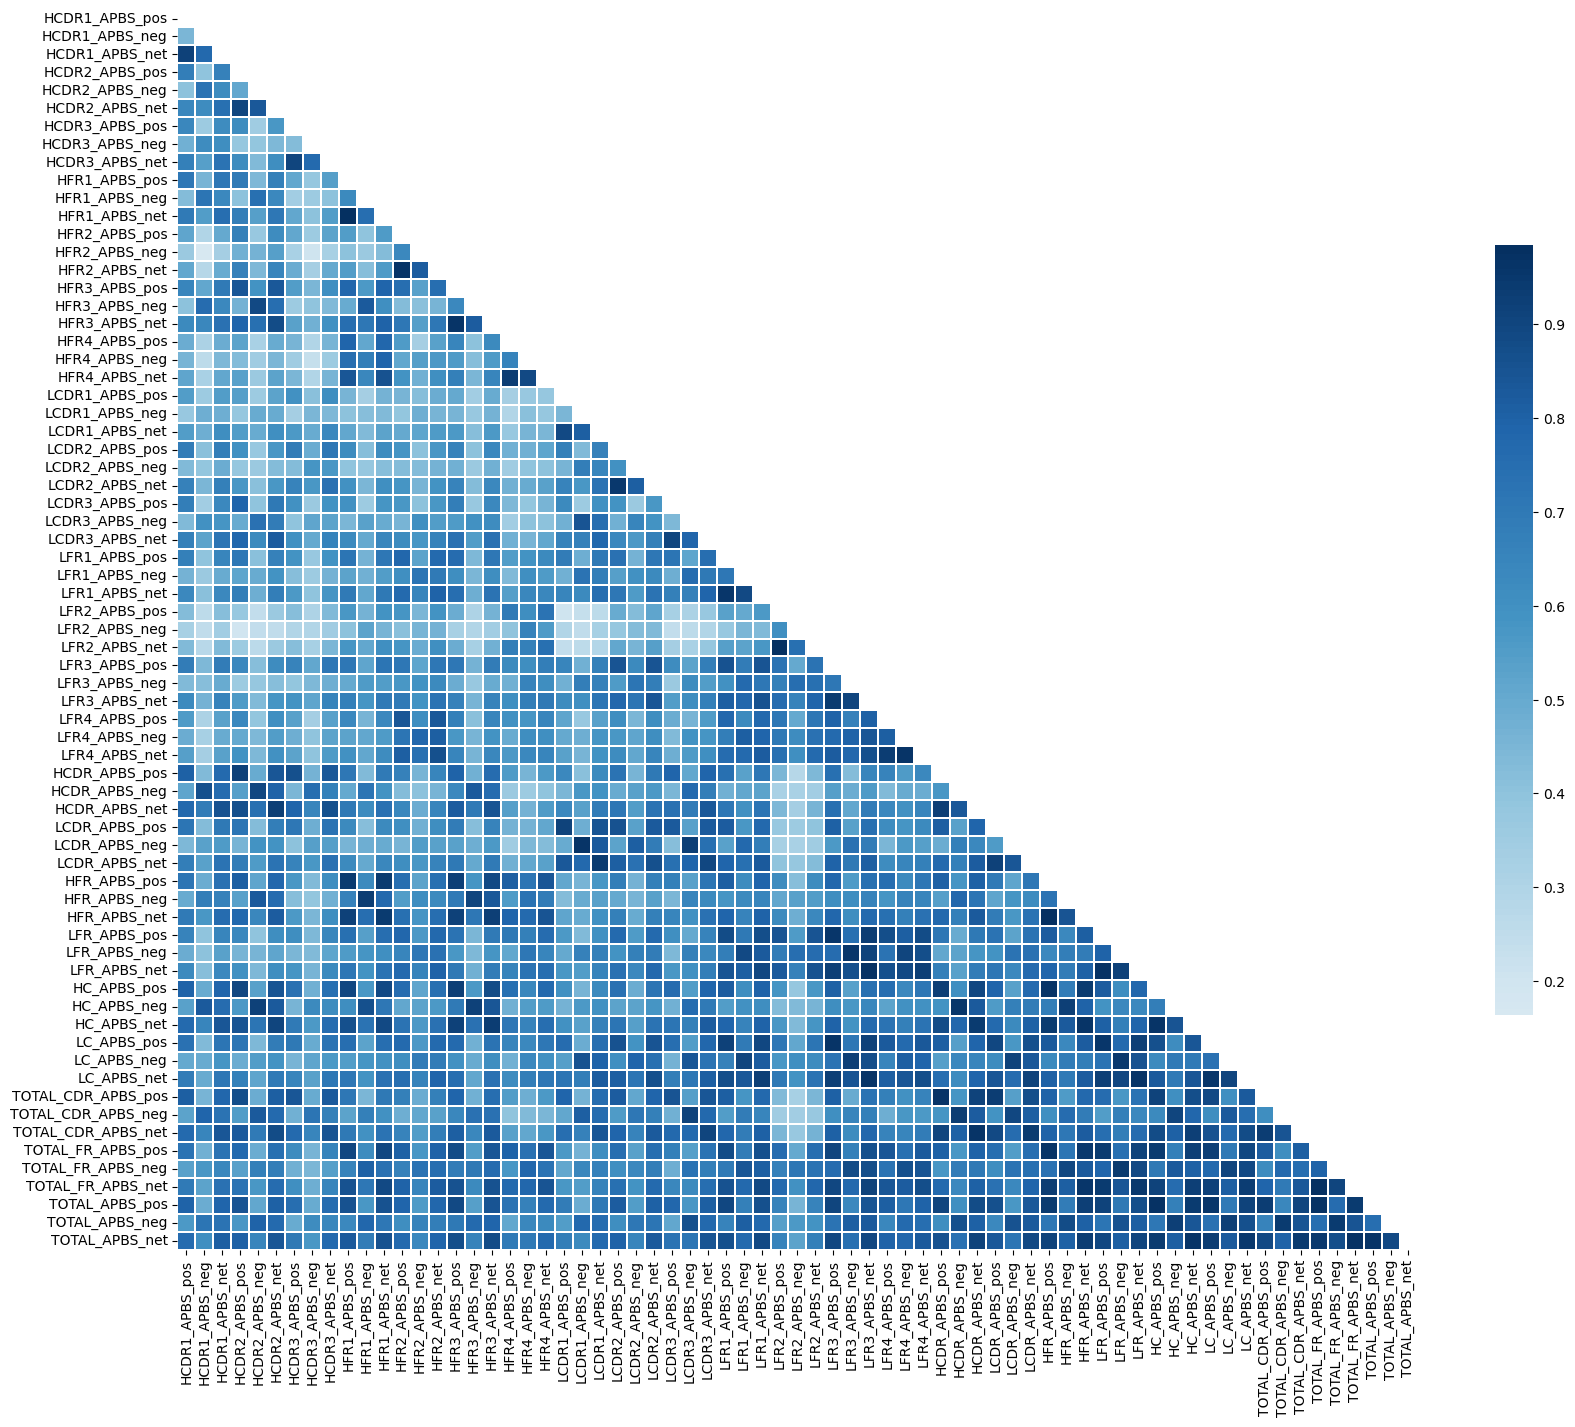

In [9]:
df_subset = df[df.columns[(df==0).mean()<1]]
plot_correlogram(df_subset.drop(['FcRn', 'Heparin'], axis = 1), figsize = (20,20))

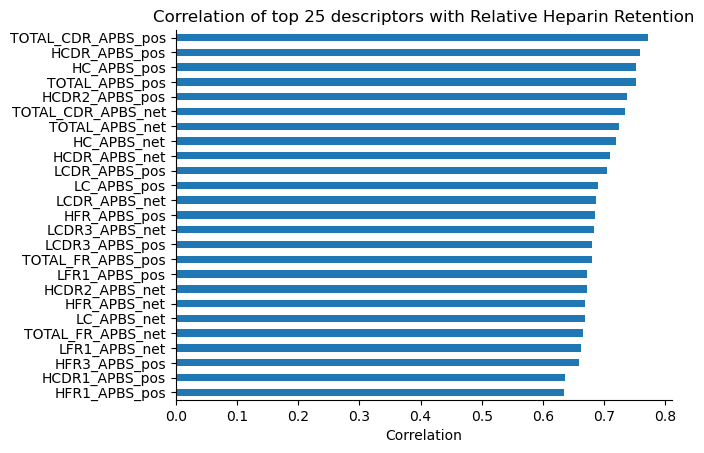

In [10]:
corr = df_subset.corr()
heparin_corr = corr.loc['Heparin'].sort_values(ascending =False)
n = 26
top_heparin = heparin_corr.head(n).tail(n-1)
ax = top_heparin.sort_values().plot(kind = 'barh')
ax.set(title='Correlation of top 25 descriptors with Relative Heparin Retention', xlabel ='Correlation')
sns.despine()

In [11]:
heparin_corr.head()

Heparin               1.000000
TOTAL_CDR_APBS_pos    0.772054
HCDR_APBS_pos         0.758522
HC_APBS_pos           0.752159
TOTAL_APBS_pos        0.751562
Name: Heparin, dtype: float64

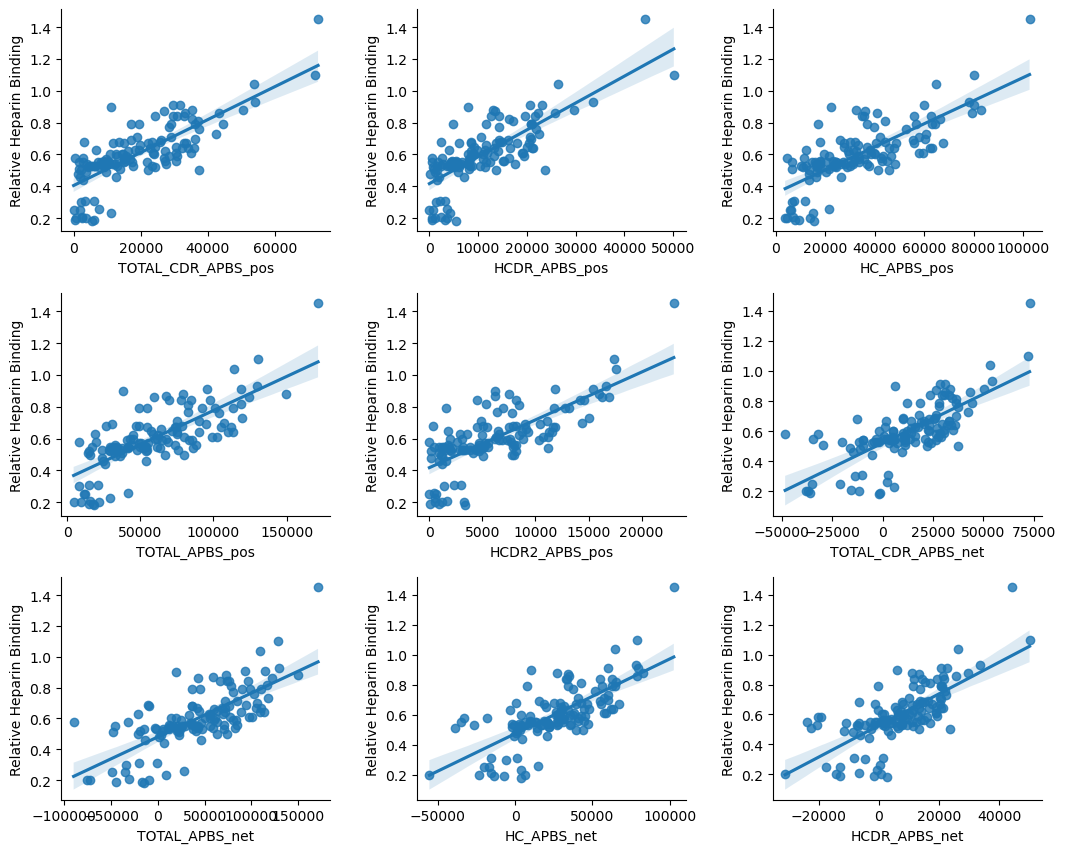

In [12]:
n = 3
width = 3.6
height = 0.8*width
fig, axes = plt.subplots(3,3, figsize = (n*width,n*height))

axes = np.ravel(axes)

for i in range(n*n): 
    x = top_heparin.index[i]

    ax = sns.regplot(data = df, x =x, y= 'Heparin' , ax = axes[i])
    ax.set(ylabel = 'Relative Heparin Binding')

sns.despine()
plt.tight_layout()

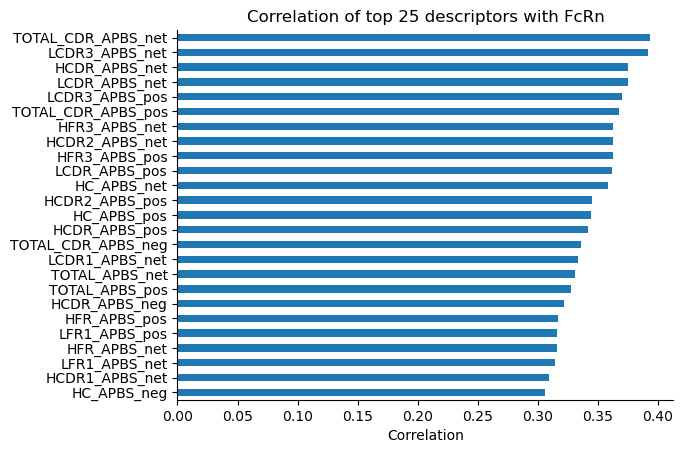

In [13]:

FcRn_corr = corr.loc['FcRn'].sort_values(ascending =False)
n = 27
top_FcRn = FcRn_corr.head(n).tail(n-2)
ax = top_FcRn.sort_values().plot(kind = 'barh')
ax.set(title='Correlation of top 25 descriptors with FcRn', xlabel ='Correlation')
sns.despine()

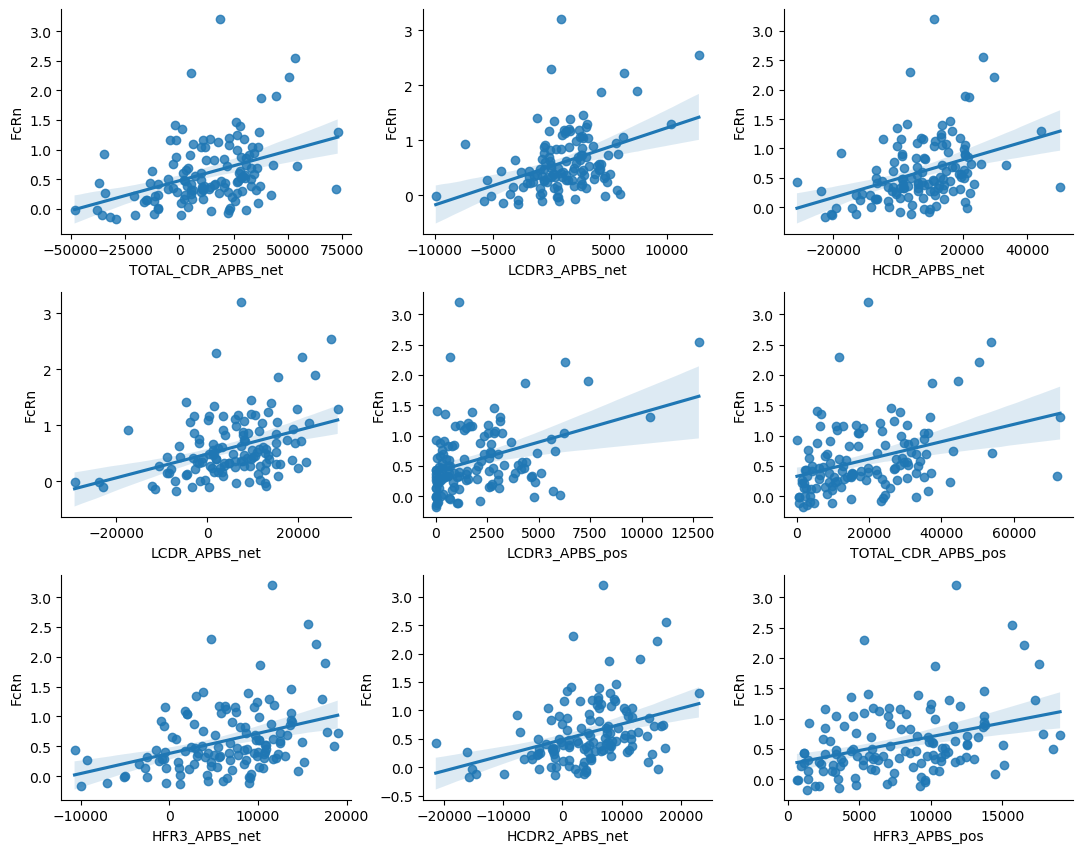

In [14]:
n = 3
width = 3.6
height = 0.8*width
fig, axes = plt.subplots(3,3, figsize = (n*width,n*height))

axes = np.ravel(axes)

for i in range(n*n): 
    x = top_FcRn.index[i]

    ax = sns.regplot(data = df, x =x, y= 'FcRn' , ax = axes[i])
    ax.set(ylabel = 'FcRn')

sns.despine()
plt.tight_layout()

### Remarks: 
Here I able to see nice correlations between relative heparin binding and the calculated descriptors for predicted therapeutic antibody structures. 

### Look at the heparin data 

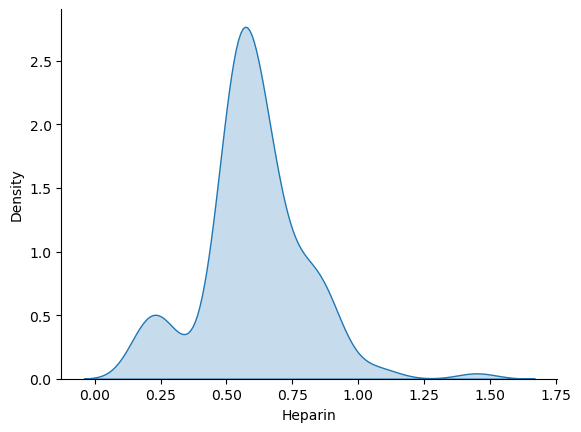

In [15]:

heparin  =df['Heparin']
sns.kdeplot(heparin, shade = True)
sns.despine()

#### Look at pairplot for most basic descriptors 

In [16]:
def should_keep(col, charge ='pos'): 
    if charge not in col: 
        return False
    for i in [1,2,3,4]: 
        if str(i) in col: 
            return True
    return False



<Axes: >

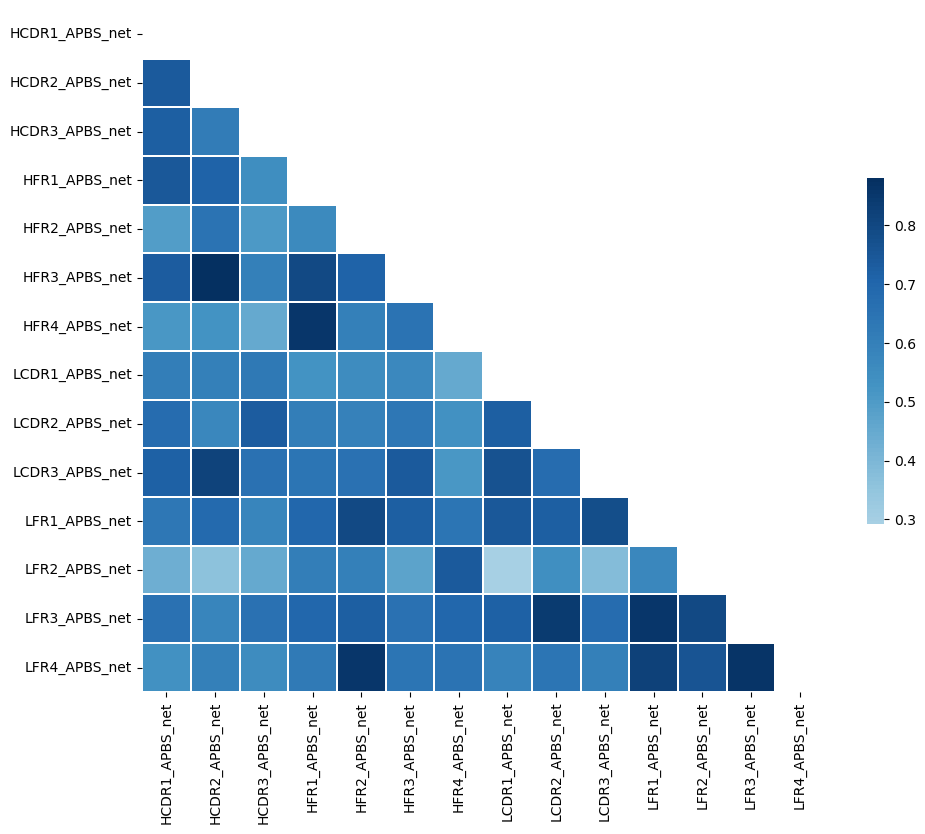

In [17]:
cols = [col for col in df.columns if should_keep(col, 'net')]
plot_correlogram(df[cols])

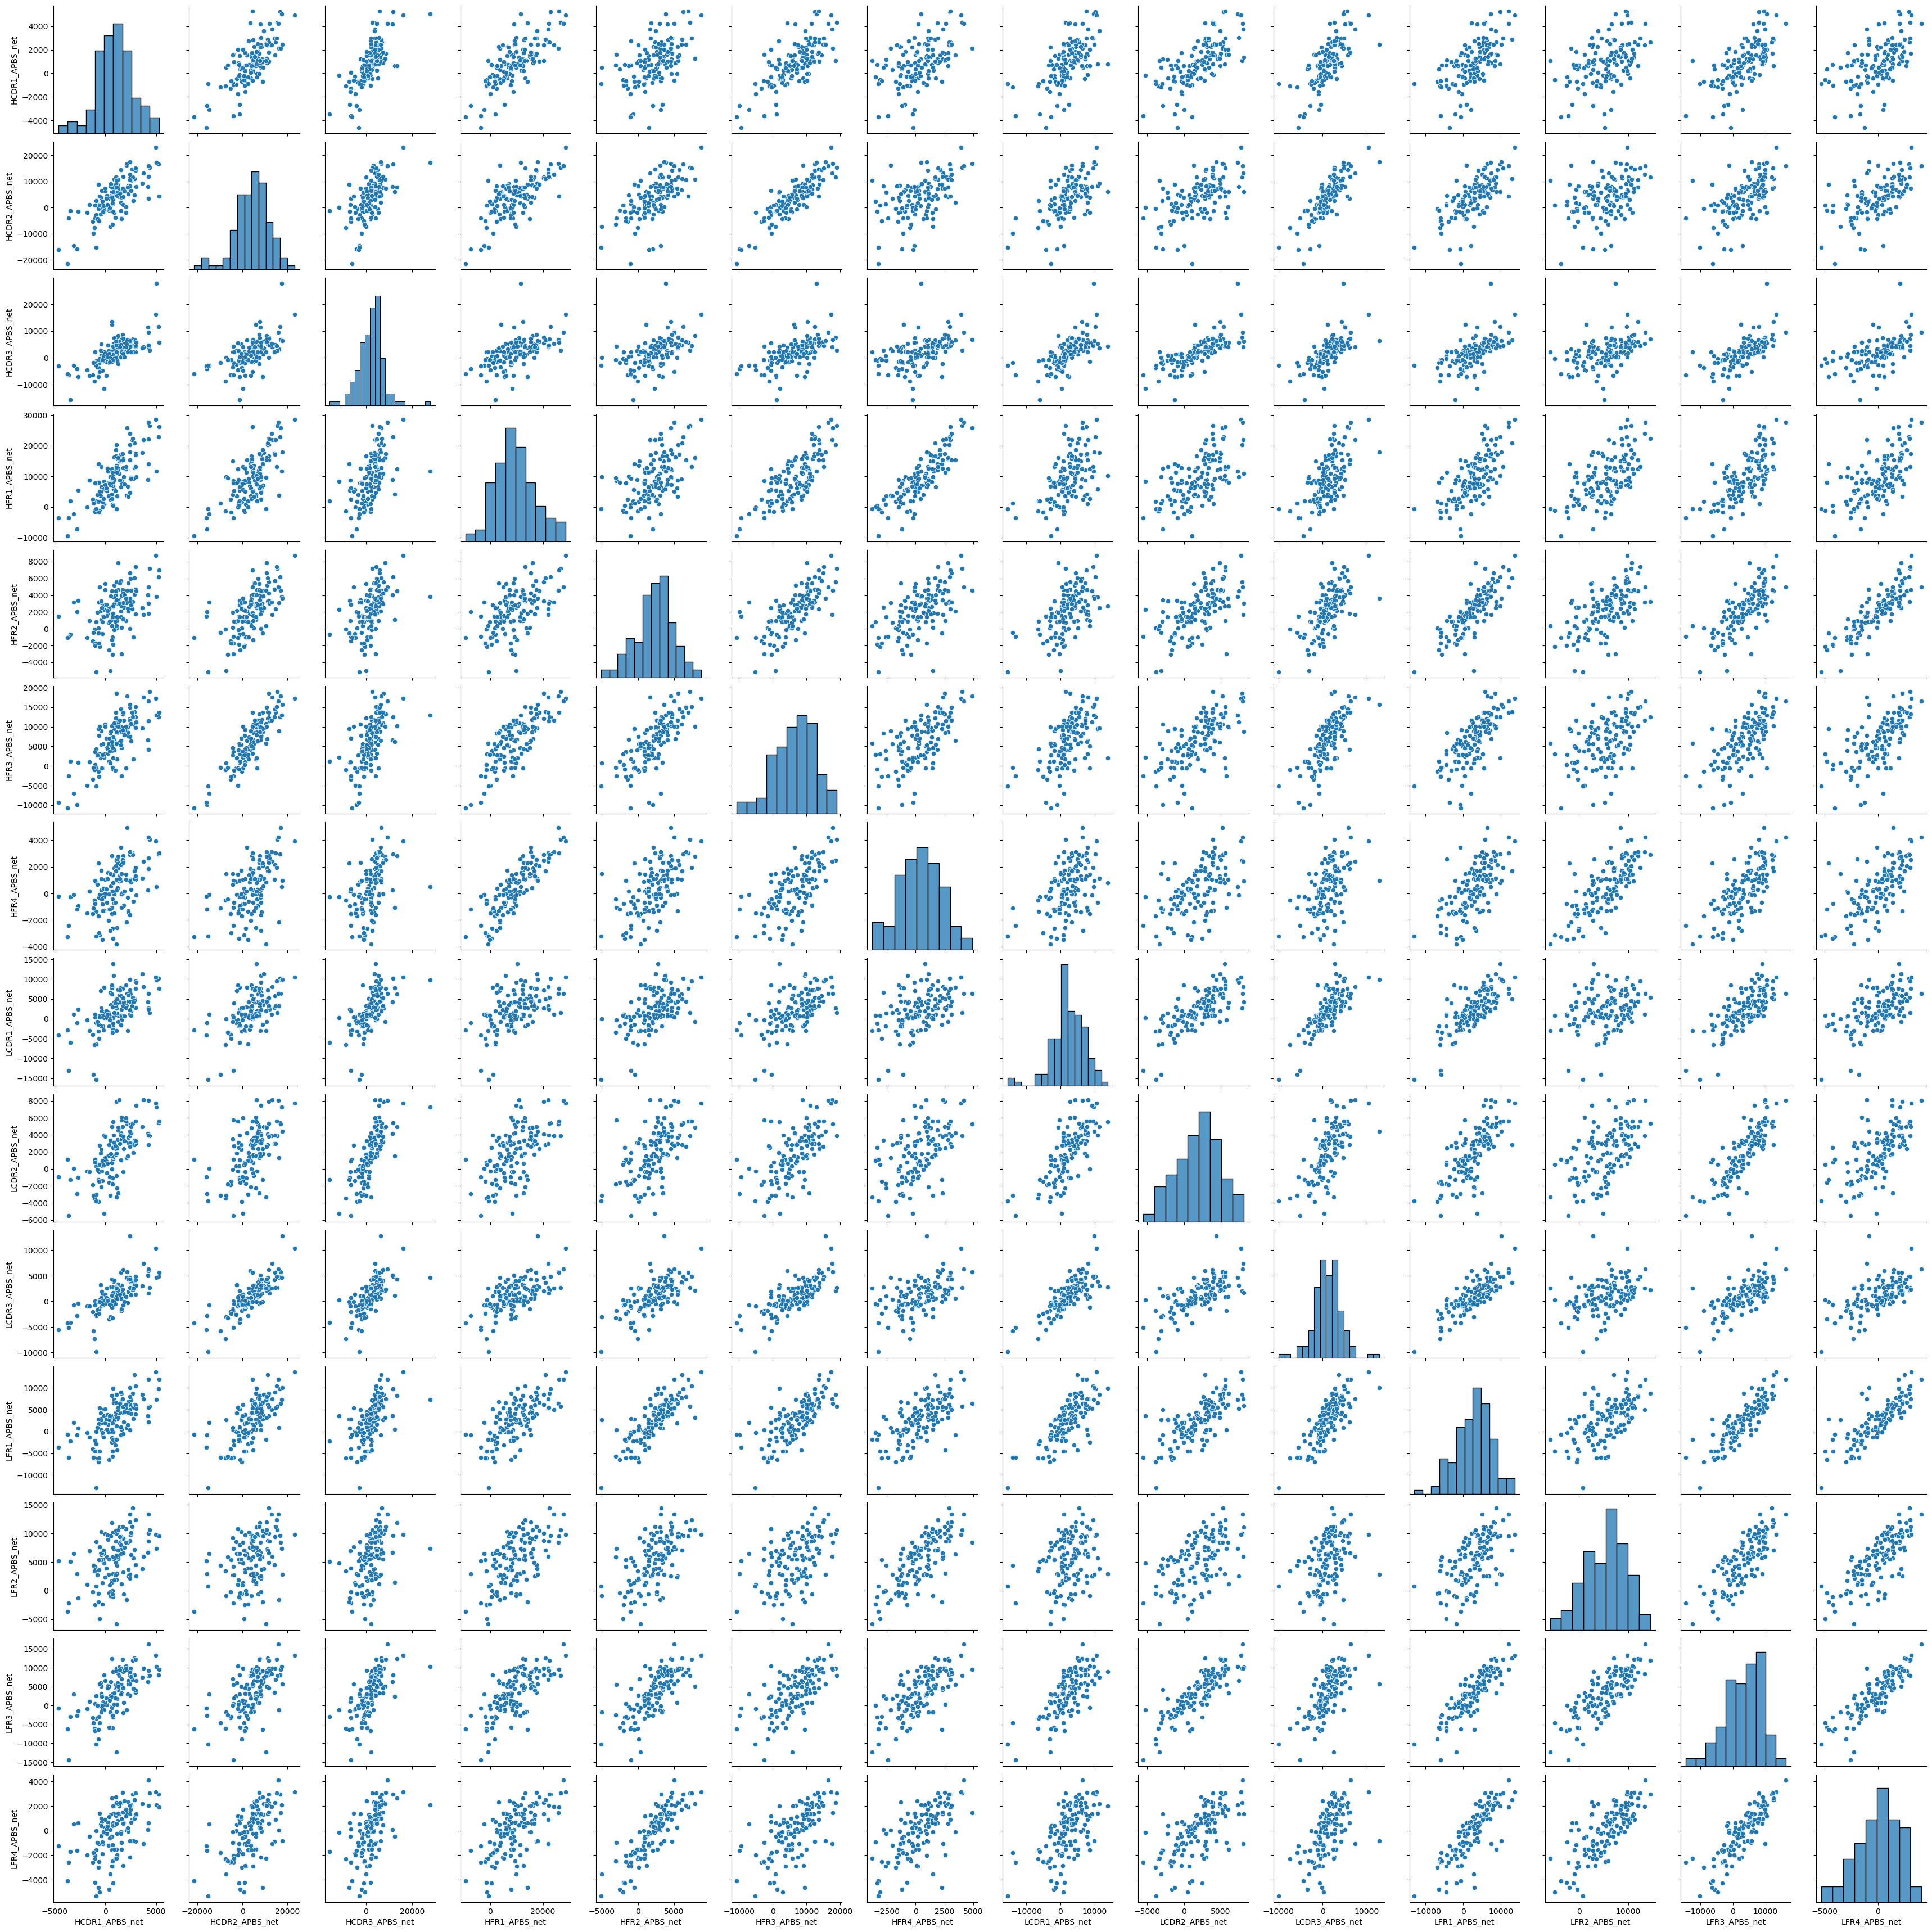

In [18]:
sns.pairplot(df[cols])

### Plot to compare with descriptor paper. 

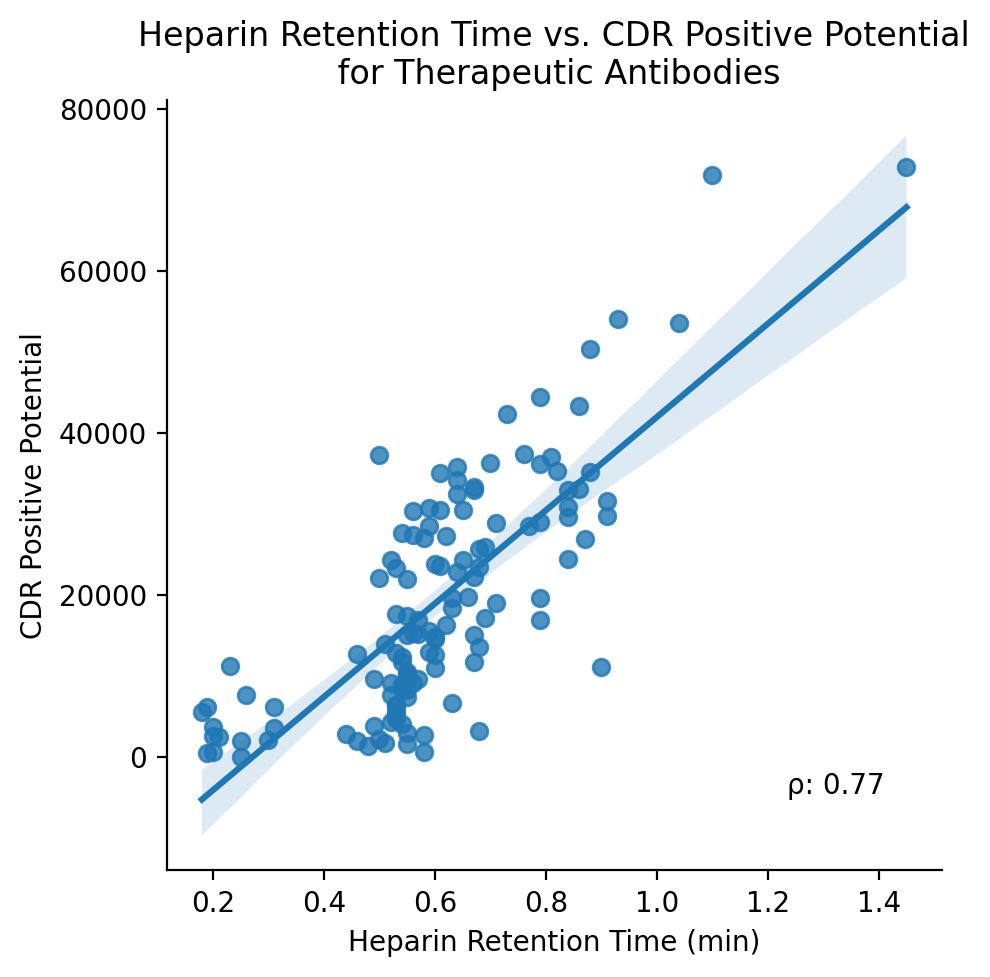

In [40]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.regplot(data = df, y ='TOTAL_CDR_APBS_pos' ,x= 'Heparin', ax = ax)
ax.set(ylabel = 'CDR Positive Potential', xlabel = 'Heparin Retention Time (min)', 
       title = 'Heparin Retention Time vs. CDR Positive Potential\n for Therapeutic Antibodies')
# Calculate the correlation coefficient
correlation_coefficient = df['TOTAL_CDR_APBS_pos'].corr(df['Heparin'])

# Annotate the correlation coefficient on the plot
ax.annotate(f"\u03C1: {correlation_coefficient:.2f}", xy=(0.80, 0.1), xycoords='axes fraction')

sns.despine()
